# Introduction

----------------------

With both the "Negative Sampling" and the "Subsampling of Frequent Words" techniques, the sampling is based on word frequency. That is, words are sampled differently depending on how many times they appear in the training data.
In this notebook, we will look at some actual word frequency data and see how the word2vec sampling functions behave on this data.

# Contents

----------------------

* [Example Word Count Data](#example_word_counts) 
    * [Download Word Frequency Data](#download)
    * [Inspecting Word Counts](#word_counts)    
* [Subsampling Frequent Words](#subsampling)
* [Negative Sampling](#negative_sampling)
    * [Sampling with Unigram Distribution](#unigram)
    * [Sampling with Modified Distribution](#modified)
* [Appendix - Google News Vocabulary by Frequency](#appendix)


# Example Word Count Data<a name="example_word_counts"></a>
--------------
Let's start by checking out some word frequency data--we'll use word counts which were extracted from a full dump of Wikipedia. 

## Download Word Frequency Data <a name="download"></a>
------------------
GitHub user IlyaSemenov was nice enough to calculate the word occurrence counts for every word in Wikipedia and share the results [in this project](https://github.com/IlyaSemenov/wikipedia-word-frequency).

Each word is followed by its count, separated by a space, with one word per line.
You can download the file directly from [here]('https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/enwiki-20150602-words-frequency.txt'), or use the below code to grab it for you.

In [2]:
import requests
import os

# Create the data subdirectory if not there.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

# URL for the text file (~22MB) containing words and 
# their counts.
url = 'https://raw.githubusercontent.com/IlyaSemenov/' \
        'wikipedia-word-frequency/master/results/' \
        'enwiki-20150602-words-frequency.txt'

print('Downloading Wikipedia word frequencies...')

# Download the file to the `/data/` subdirectory.
r = requests.get(url, allow_redirects=True)
with open('./data/enwiki-20150602-words-frequency.txt', 'wb') as f:
    f.write(r.content)

print('    Done.')

    Done.


## Inspecting Word Counts<a name="word_counts"></a>
-------------------------
Let's start by reading in the words and their counts as two separate lists. Conveniently, they have already been sorted by descending frequency.

In [3]:
%%time

words = []
word_counts = []

print('Reading in word counts...')

# Open the file and read line by line.
with open('./data/enwiki-20150602-words-frequency.txt', 
          'r', encoding='utf-8') as f:
    for line in f:
        # Remove the newline.
        line = line.rstrip('\n')        
        
        # The words and counts are separated by a single space.
        (word, count) = line.split(' ')
        
        # Store the word and its count.
        words.append(word)
        word_counts.append(int(count))

print('   Done.')

Reading in word counts...
   Done.
Wall time: 1.89 s


--------
Let's look at a few basic properties of the data before applying it to negative sampling.

There appears to be 1.9M words in the vocabulary, and 1.5B total word occurrences! 

In [4]:
import numpy as np

# Convert the list to a numpy array so we can do math on it easily.
word_counts = np.asarray(word_counts)

# Total words in the training set.
# Make sure to sum with int64, otherwise it will overflow!
total_words = np.sum(word_counts, dtype=np.int64)

print('Number of words in vocabulary: {:,}\n'.format(len(words)))
print('Total word occurrences in Wikipedia: {:,}\n'.format(total_words))

Number of words in vocabulary: 1,901,124

Total word occurrences in Wikipedia: 1,562,759,958



Just out of curiosity, here are the most frequent and least frequent words.

In [5]:
print('The 10 most frequest words:\n')
print('  --Count--    --Word--')

# For the first ten word counts...
for i in range(10):
    # Print the count with commas, and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_counts[i], words[i]))


The 10 most frequest words:

  --Count--    --Word--
 121,935,704     the
  58,025,263     of
  49,845,260     and
  49,083,414     in
  34,840,354     to
  20,781,727     was
  17,634,866     is
  14,371,522     for
  13,887,627     as
  13,660,464     on


In [6]:
print('The 10 least frequest words:\n')
print('  --Count--    --Word--')

# Go backwards through the last 10 indeces...
for i in range(-1, -10, -1):
    # Print the count with commas, and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_counts[i], words[i]))

The 10 least frequest words:

  --Count--    --Word--
           3     image-filled
           3     фантазия
           3     freysgoði
           3     hotenow
           3     glampers
           3     eizin
           3     eto-ecologist
           3     download-to-rent
           3     chasnupp-iii


# Subsampling Frequent Words <a name="subsampling"></a>
------------------

When given a list of words representing a sentence, the word2vec algorithm goes through each word and rolls some dice to decide whether to keep each word or cut it from the sentence. 

The following equation is used to calculate the probability of **keeping** word $ w_i $, where $ z(w_i) $ is the fraction of the total word occurrences which are word 'i'.

$ P(w_i) = (\sqrt{\frac{z(w_i)}{0.001}} + 1) \cdot \frac{0.001}{z(w_i)} $

The value 0.001 is a parameter which can be modified. Smaller values of 'sample' mean words are less likely to be kept / more likely to be tossed.

Let's try applying this formula to our Wikipedia word data to see what happens.

In [7]:
# Divide each word's occurrence count by the total number of words to get that z(w_i) number.
word_fractions = word_counts / float(total_words)

# Coefficient to control how aggressively we subsample.
coeff = 0.001

# Let's calculate the probabilities for all words.
#
# Numpy is handling a lot for us here. It knows that when we divide
# an array by a scalar (like word_fractions / coeff) we mean to divide
# each element by the scalar. 
# And when we multiple two arrays together, it knows to multiply each
# element of the arrays together. (If we had wanted the dot product
# instead, we would use np.dot)
word_sample_rates = (np.sqrt(word_fractions / coeff) + 1) * (coeff / word_fractions)

---------------
Now that we have the sampling probabilities calculated for all words, let's see what the probabilities are for the most common words. 

In [8]:
print("--Rank--  --Word--  --Probability to keep--")

# Go through the words (from most frequent down) until we find
# the first word which will always be kept.
for i in range(len(words)):
    print('%4d %10s       %.0f%%' % (i, words[i], word_sample_rates[i]*100.0))
    
    # Stop when we go above 100%
    if word_sample_rates[i] > 1.0:
        break

--Rank--  --Word--  --Probability to keep--
   0        the       13%
   1         of       19%
   2        and       21%
   3         in       21%
   4         to       26%
   5        was       35%
   6         is       39%
   7        for       44%
   8         as       45%
   9         on       45%
  10       with       49%
  11         by       49%
  12         he       53%
  13       that       56%
  14         at       58%
  15       from       59%
  16        his       61%
  17         it       63%
  18         an       72%
  19       were       80%
  20        are       82%
  21      which       85%
  22       this       92%
  23       also       94%
  24         be       95%
  25         or       97%
  26        has       98%
  27        had       101%


These results surprised me. For this dataset, the subsampling equation (with coefficient 0.001) only removes the top 27 stop words. Perhaps this is the intended behavior, or perhaps the Google News dataset had a different word frequency distribution. 

As we'll see in the next section, though, this subsampling does have a significant impact on the size of the training set.

-----------

With the sampling rates calculated, we can now calculate the expected reduction in size of the training set. 
Note that this sampling is not a pre-processing step, but rather a decision that's made on each word as we go through the training data. The training dataset is not modified, either--each training pass will remove different words, and the actual number of words removed will vary. The calculation below is just an average.

In [9]:
# Limit the sample rates to a max value of 1.0.
wsr = np.clip(word_sample_rates, 0.0, 1.0)

# Multiply each word's count by its sample rate, and sum the result
# to get the expected number of sampled words.
sampled_words = np.dot(word_counts, wsr)

# Report the result.
print("\nOf {:,} words in the training set, on average {:,} will be sampled.".format(total_words, int(sampled_words)))

# By what percent did we reduce the training set?
percent_sampled = (total_words - sampled_words) / total_words * 100.0

print("\nThis is a %.2f%% reduction in size." % (percent_sampled))


Of 1,562,759,958 words in the training set, on average 1,216,199,161 will be sampled.

This is a 22.18% reduction in size.


--------
Below is some code for taking an example sentence and displaying the sampling probabilities for each word.

In [10]:
# Let's define this as a function so we can re-use it on other sentences.
def subsample_sentence(sentence, word_sample_rates):

    print("\n%8s  %15s    %s" % ('--Rank--', '--Word--', '--Probability to keep--'))

    # For each word in the sentence
    for word in sentence:
        # Find the word's index.
        i = words.index(word)
        
        #print(word_fractions[i])
        
        word_prob = word_sample_rates[i]
        
        if word_prob > 1.0:
            word_prob = 1.0
        
        print('%8d %15s       %.0f%%' % (i, word, word_prob*100.0))
        
        
# Let's try a classic example.
sentence = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
subsample_sentence(sentence, word_sample_rates)    

# And now something arbitrary.
sentence = ['below', 'is', 'some', 'code', 'for', 'taking', 'an', 'example', 'sentence', 'and', 'displaying', 'the', 'sampling', 'probabilities', 'for', 'each', 'word']
subsample_sentence(sentence, word_sample_rates) 


--Rank--         --Word--    --Probability to keep--
       0             the       13%
    4435           quick       100%
     846           brown       100%
    1895             fox       100%
    9290          jumped       100%
      54            over       100%
       0             the       13%
   16176            lazy       100%
    2406             dog       100%

--Rank--         --Word--    --Probability to keep--
     708           below       100%
       6              is       39%
      58            some       100%
    1198            code       100%
       7             for       44%
     752          taking       100%
      18              an       72%
     411         example       100%
    3579        sentence       100%
       2             and       21%
   10077      displaying       100%
       0             the       13%
   10173        sampling       100%
   20724   probabilities       100%
       7             for       44%
     134            each       100%


# Negative Sampling<a name="negative_sampling"></a>
----------------
Recall that when training the word2vec neural network, we only update the weights for a small number of "negative" words (that is, words which *are not* in the input word's context). This is referred to as negative sampling. 

The negative samples are selected at random, but with a probability tied to the word's frequency in the training data. That is, more common words are selected more often as negative samples.

## Sampling with Unigram Distribution<a name="unigram"></a>
----------------
The most straightforward sampling for negative words would be to select them with the same probability as their occurrence in the training data: 

$ P(w_i) = \frac{  f(w_i)  }{\sum_{j=0}^{n}\left(  f(w_j) \right) } $

That is, the probability of selecting word 'i' is just the number of occurrences of word i over the total number of word occurrences in the corpus.

Let's plot the word counts to see what this distribution would look like.

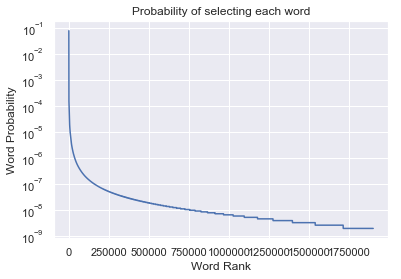

In [11]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

# For each word, calculate the probability that you would choose it
# at random from the training set.
word_probs = word_counts / float(total_words)

# The x-axis will just be the word "ranking". 
# Because the words are all sorted by frequency, a
# word's index in the list is also its rank.
word_ranks = range(0, len(words))

sns.set(style='darkgrid')

# Plot the word counts on a logarithmic scale.
plt.yscale('log')
plt.plot(word_ranks, word_probs)

plt.xlabel('Word Rank')
plt.ylabel('Word Probability')
plt.title('Probability of selecting each word')

plt.show()

----------------
It looks like the elbow of the plot is somewhere around word 125k, so let's check out that region.

It's interesting to see that these are still (mostly) reasonable words.

In [12]:
print('Words near elbow at 125,000:\n')
print('%30s    --Count--' % '--Word--')

# For the first ten word counts...
for i in range(125000, 125010):    
    print('%30s    %d' % (words[i], word_counts[i]))

Words near elbow at 125,000:

                      --Word--    --Count--
               petroleum-based    222
                        jepara    222
                   reperfusion    222
                    inscribing    222
                     entreated    222
                        markaz    222
                           bng    222
                           lut    222
                      tibialis    222
                   hairstyling    222


## Sampling with Modified Distribution<a name="modified"></a>
---------
The word2vec authors found that a slight modification to this function produced the best results. They raised each word count to the 3/4 power:

$ P(w_i) = \frac{  {f(w_i)}^{3/4}  }{\sum_{j=0}^{n}\left(  {f(w_j)}^{3/4} \right) } $

Let's calculate these modified probabilities, and plot them together with the unigram distribution to see the difference.

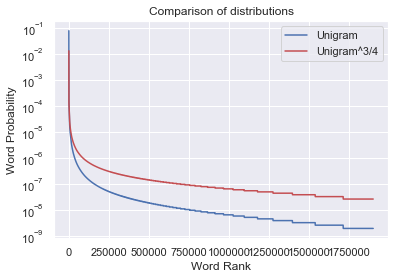

In [13]:
# Raise all word counts to the 3/4 power.
word_counts_34 = word_counts**0.75

# Sum these to get the denominator.
total_words_34 = np.sum(word_counts_34)

# Calculate the word probabilities
word_probs_34 = word_counts_34 / total_words_34

# Create a new figure and retrieve the axis object so we can
# plot both distrubtions together.
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot both distributions.
ax1.plot(word_ranks, word_probs,    c='b', label='Unigram')
ax1.plot(word_ranks, word_probs_34, c='r', label='Unigram^3/4')

# Show the probabilities in log scale.
plt.yscale('log')

# Add the legend and label the plot.
plt.legend()
plt.xlabel('Word Rank')
plt.ylabel('Word Probability')
plt.title('Comparison of distributions')

plt.show()

We can see that, on the very far left, the modified distribution **decreases** probability for the most frequent words. But for the majority of the words, the modified distribution **increases** their probability. 

Out of curiosity, where does it flip?

In [14]:
for i in range(len(word_probs)):
    if word_probs[i] < word_probs_34[i]:
        print("'%s', ranked %d, is the first word which has a " \
              "higher probability with the modified distribution." % (words[i], i))
        print("This means probability is decreased for only " \
              "the top %.2f%% of the vocabulary." % (float(i) / float(len(word_probs)) * 100.0))
        print("The word has unigram probability %G, " \
              "and probability %G with the modified distribution." % (word_probs[i], word_probs_34[i]))
        print("The word occurs {:,} times in the corpus\n".format(word_counts[i]))
        break
    

'crown', ranked 1798, is the first word which has a higher probability with the modified distribution.
This means probability is decreased for only the top 0.09% of the vocabulary.
The word has unigram probability 6.37987E-05, and probability 6.38053E-05 with the modified distribution.
The word occurs 99,702 times in the corpus



# Appendix - Google News Vocabulary by Frequency <a name="appendix"></a>
--------------------------

If you load the Google News model in gensim (as we did in Chapter 1), you can look at, for example, `model.vocab["hello"].count`. I assumed this was the word occurrence count that we want, but it's actually just the word's _ranking_. So if you sort the 3M words in the Google News vocabulary by this "count" property, you'll just get the correct ranking of the words, but not the actual number of occurrences.

The below code demonstrates this. 

In [15]:
%%time

from gensim.corpora import Dictionary

import gensim

filepath = './data/GoogleNews-vectors-negative300.bin'

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

# Get the list of words in the vocabulary.
words = model.vocab.keys()

# Create a corresponding list of the count for each word.
word_ranks = []
for word in words:
    word_ranks.append(model.vocab[word].count)
    
# Sort both lists by the word counts, descending (most frequent first).
# Please forgive the python nastiness! We're combining the lists,
# sorting by the counts, then splitting them back into two separate
# lists.
word_ranks, words = map(list, zip(*sorted(zip(word_ranks, words), reverse=True)))

print('\nThe 10 most frequest words:\n')
print('  --Rank--    --Word--')

# For the 10 most frequent words...
for i in range(10):
    # Print the rank with commas, and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_ranks[i], words[i]))

print('\nThe 10 least frequest words:\n')
print('  --Rank--    --Word--')

# Go backwards through the last 10 indeces...
for i in range(-1, -10, -1):
    # Print the count with commas, and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_ranks[i], words[i]))


The 10 most frequest words:

  --Rank--    --Word--
   3,000,000     </s>
   2,999,999     in
   2,999,998     for
   2,999,997     that
   2,999,996     is
   2,999,995     on
   2,999,994     ##
   2,999,993     The
   2,999,992     with
   2,999,991     said

The 10 least frequest words:

  --Rank--    --Word--
           1     snowcapped_Caucasus
           2     pulverizes_boulders
           3     Mezze_Cafe
           4     Bim_Skala_Bim
           5     RAFFAELE
           6     righthander_Kyle_Drabek
           7     Thirsty_Owl
           8     divider_pistons
           9     Shilpa_Goenka
Wall time: 46.4 s
